### OpenCV: Open Computer Vision Library


In [2]:
import cv2
import numpy as np

### The screen is a 3d matrix

In [2]:
frame = np.ones([480, 680,3], dtype=np.uint8)

$$
M=
  \begin{bmatrix}
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
    ... & ... & ... & ... \\
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
  \end{bmatrix}
$$

In [3]:
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### What about a wite screen?

$$
M=
  \begin{bmatrix}
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
    ... & ... & ... & ... \\
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
  \end{bmatrix}
$$

In [6]:
frame = np.ones([480, 680,3], dtype=np.uint8) * 255
cv2.imshow("frame", frame)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Lets have some fun, some cube fun!
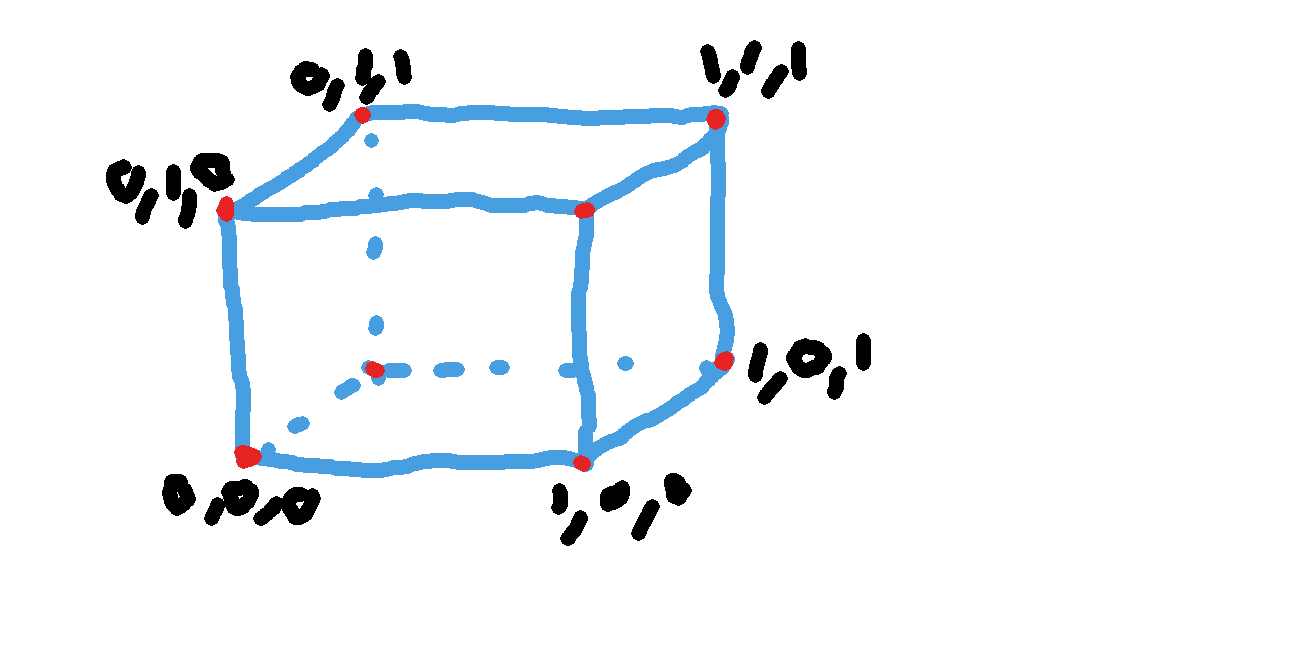
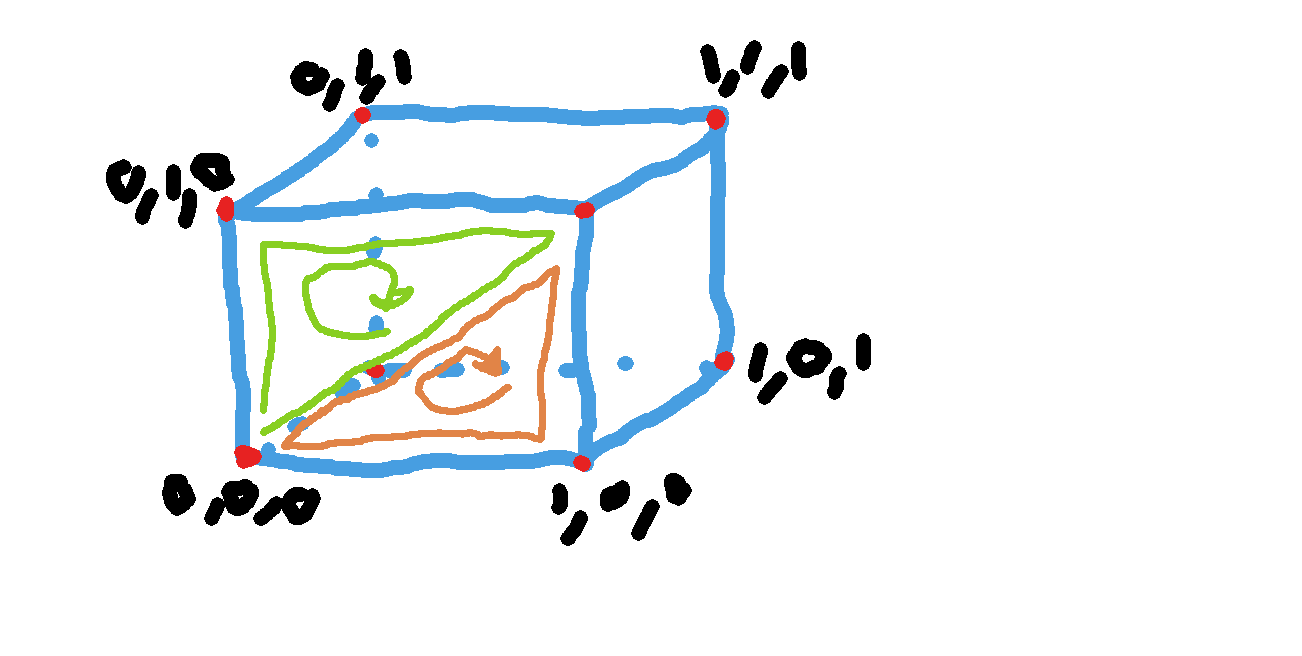
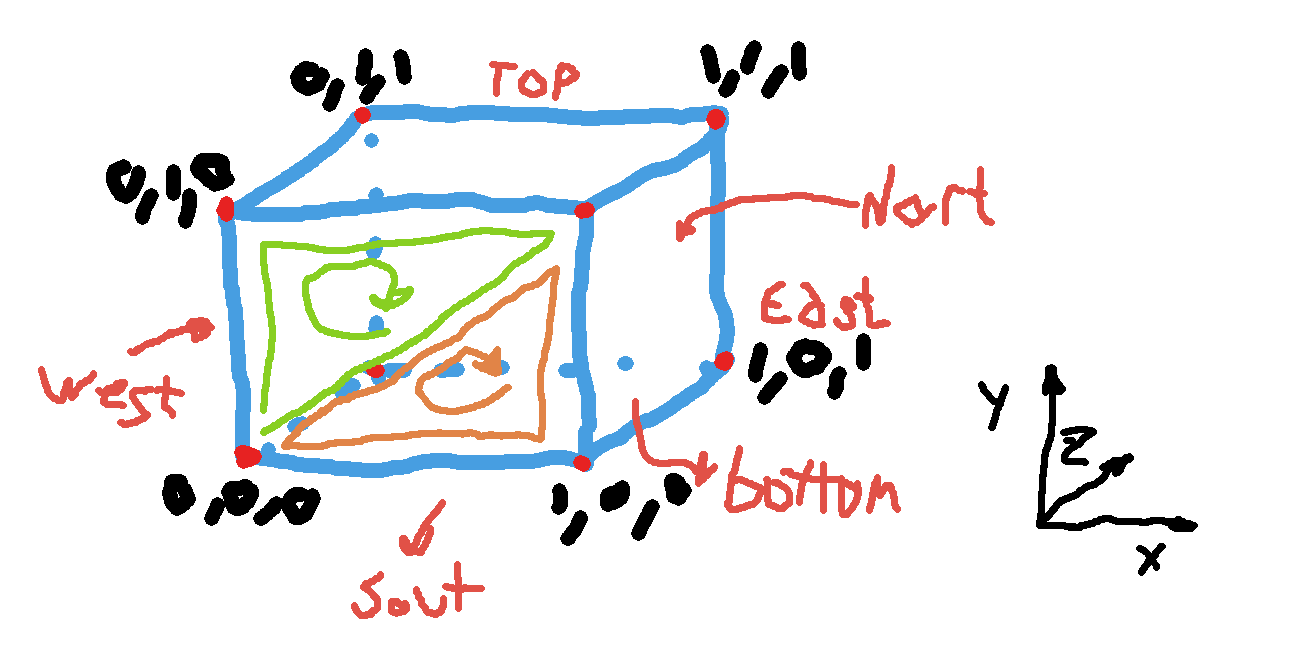

In [5]:
cubito = np.array([
        [[1, 1, 1], [0, 1, 0], [0, 1, 1]],
        [[0, 1, 0], [1, 0, 0], [0, 0, 0]],

        [[1, 1, 0], [1, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [1, 0, 0], [1, 0, 1]],

        [[0, 1, 1], [0, 0, 0], [0, 0, 1]],
        [[1, 1, 1], [0, 0, 1], [1, 0, 1]],

        [[1, 1, 1], [1, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [1, 1, 0], [1, 0, 0]],

        [[1, 1, 0], [1, 1, 1], [1, 0, 1]],
        [[0, 0, 1], [0, 0, 0], [1, 0, 0]],

        [[0, 1, 1], [0, 1, 0], [0, 0, 0]],
        [[1, 1, 1], [0, 1, 1], [0, 0, 1]],
])

### How can we proyect our cube into the screen?
## Proyection Matrix
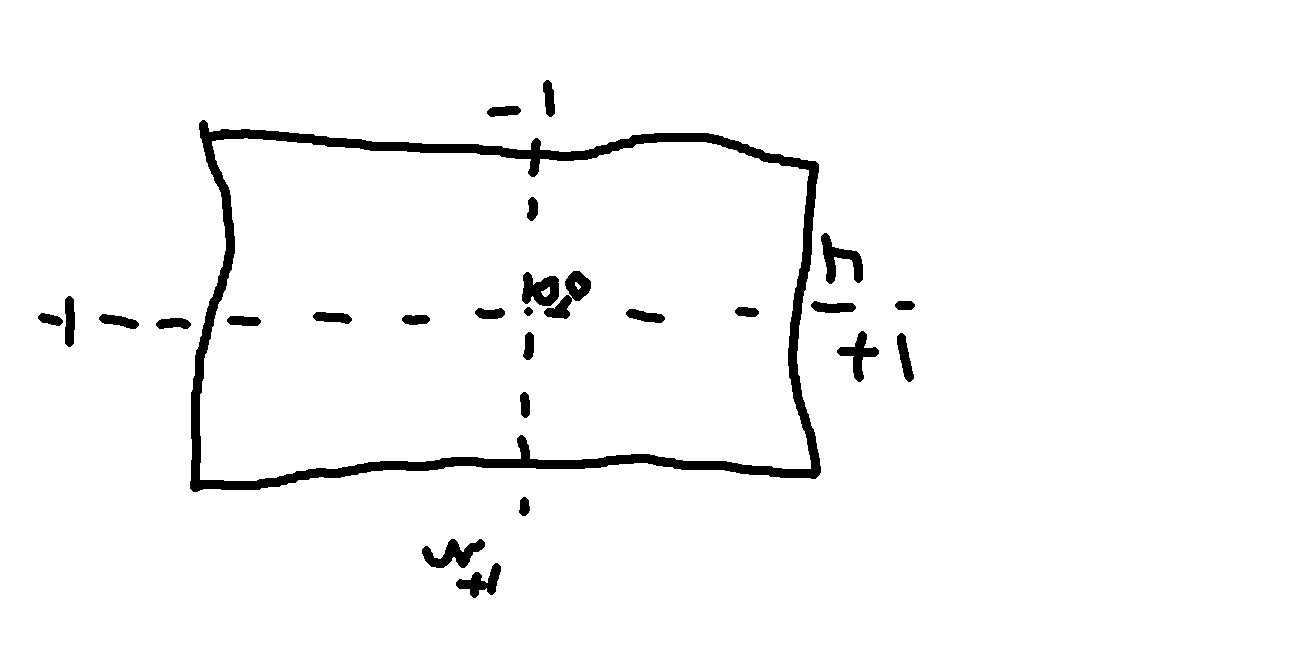
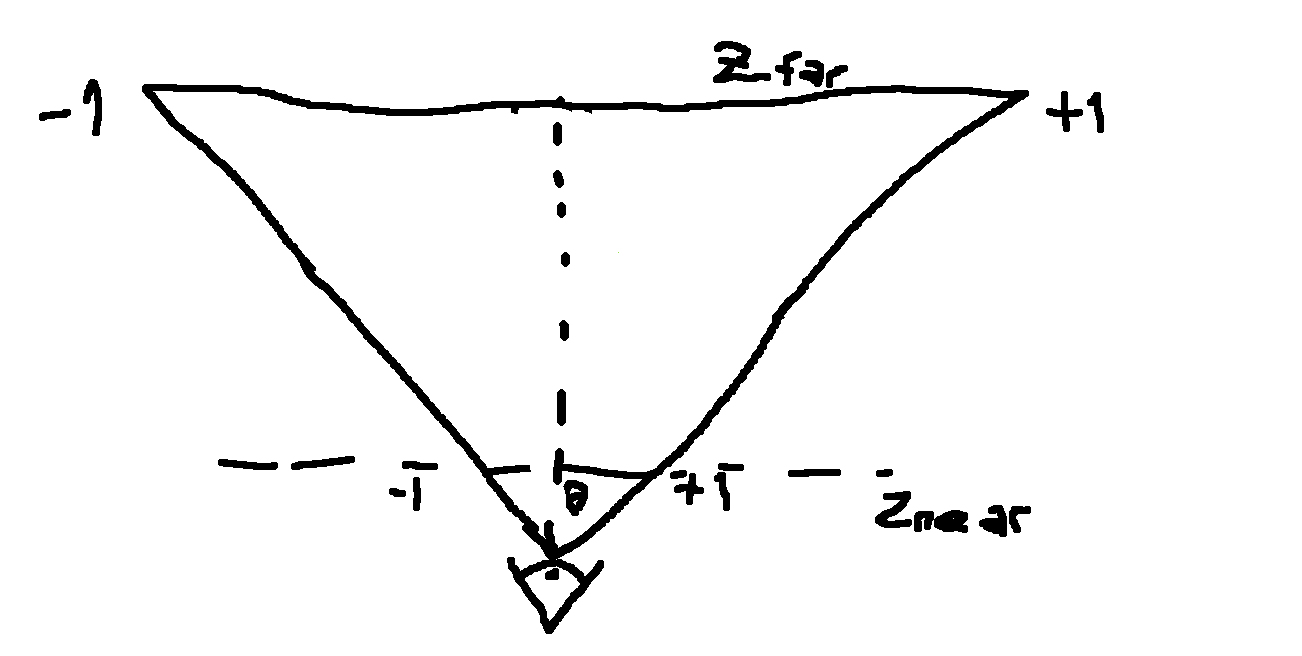

$$
M=
  \begin{bmatrix}
    (\dfrac{h}{w}) * \dfrac{1}{\tan(\tfrac{\Theta}{2})} & 0 & 0 & 0 \\
    0 & \dfrac{1}{\tan(\tfrac{\Theta}{2})} & 0 & 0 \\
    0 & 0 & \dfrac{Zfar}{Zfar-Znear} & 1\\
    0 & 0 & \dfrac{-Zfar* Znear}{Zfar-Znear} & 0\\
  \end{bmatrix}
$$

#### Using some normal people words we get
Aspect Ratio<br>
Field of view<br>
Z normalization <br>
$$
Proyection=
  \begin{bmatrix}
    A * F & 0 & 0 & 0 \\
    0 & F & 0 & 0 \\
    0 & 0 & Q & 1\\
    0 & 0 & Q-Znear & 0\\
  \end{bmatrix}
$$

Now what we want is to multiply each element by the proyection matrix
$$
\dfrac{AFx}{z} , \dfrac{Fy}{z} , \dfrac{Q - ZnearQ}{z}
$$

In [3]:
frame = np.ones([480, 680,3], dtype=np.uint8)
screen_height, screen_width, z = frame.shape

f_near = 0.1
f_far = 1000
f_fov = 90
f_aspect_ratio = screen_height / screen_width
f_fov_rad = 1 / np.tan(f_fov * 0.5 /180 * np.pi)

af = f_aspect_ratio * f_fov_rad
f = f_fov_rad
q = f_far/(f_far-f_near)

mat_proj =  np.matrix([[ af, 0,          0, 0], 
                       [  0, f,          0, 0], 
                       [  0, 0,          q, 1],
                       [  0, 0,  -f_near*q, 0]])

def persp_transf(face):
    face = np.append(face, np.ones([3,1]), axis=1)
    res = []
    for line in face:
        l = np.matmul(line, mat_proj)
        w = l.item(3)
        if(w !=0):
            l = l * 1/w
        
        l=l[:,:3]
        res.append(l)
    return np.squeeze(np.asarray(res))

### Can we render now?

In [9]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape  
        
        points = persp_transf(points)
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

In [10]:
frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

oh, wait! My cube is 1 pixel big.<br>
First I need to move the cube because the proyection matrix gives me a cube between -1 and 1

$$
Translation=
  \begin{bmatrix}
    1 & 1 & 0 \\
    1 & 1 & 0 \\
    1 & 1 & 0 \\
  \end{bmatrix}
$$

$$  
Scale=
  \begin{bmatrix}
    0.5*w & 0.5*h & 1 \\
    0.5*w & 0.5*h & 1 \\
    0.5*w & 0.5*h & 1 \\
  \end{bmatrix}
$$

In [11]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### So Cute!<br>
But we have a little problem. The cube is inside our eye! Lets move it a little bit far

$$
Translation=
  \begin{bmatrix}
    1 & 1 & 3 \\
    1 & 1 & 3 \\
    1 & 1 & 3 \\
  \end{bmatrix}
$$

In [13]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Let the fun begin!

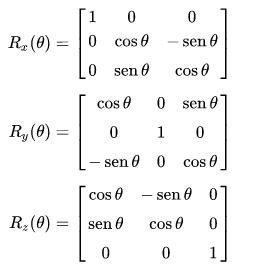

In [14]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False
        cv2.waitKey(1)
        


Cool right?<br>
But in real life we shouldn't see the wires
Let me introduce you to Normals and dot product
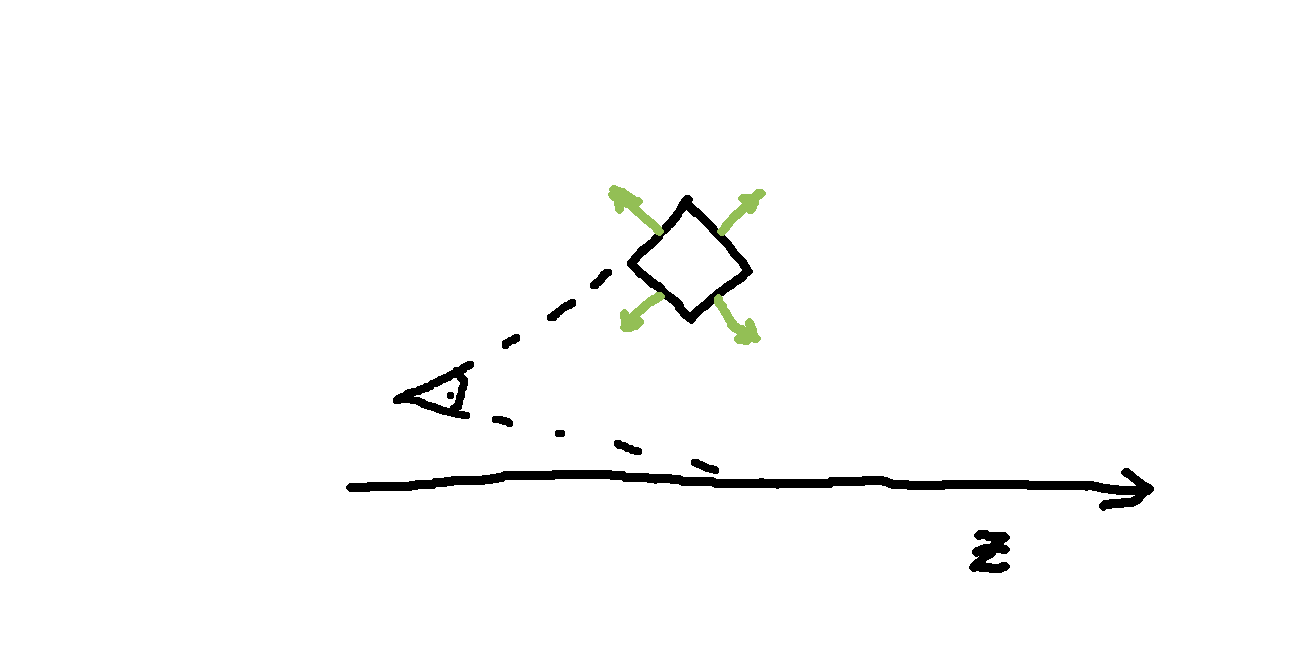

In [15]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])

            color =(255, 255, 255)
            cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        rendering = False


### wires are for kids. I want to see solids!

In [16]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255])
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
            

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        rendering = False


### Turns out that our perception of 3D objects is given by how light interacts with the world so... Let there be light!

$$
directionalLight=
  \begin{bmatrix}
    0 & 0 & -1 \\
  \end{bmatrix}
$$

![directional_light.png](directional_light.png)

In [6]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,0,-1])
angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        rendering = False


### Simple figures are cool and all but what about using any type of 3D object?
Turns out there is something called OBJ object in any 3D modeling software and with a little bit of love and google we can read it!

In [7]:
from objloader_simple import OBJ
fox = OBJ("models/fox.obj")

```
Blender v2.82 (sub 7) OBJ File: 'fox.blend'
www.blender.org
o Cube


v -0.335911 1.089254 -2.793474
v -0.507677 1.628976 -2.937910
v -0.566896 1.049088 -3.192348

s off

f 51 15 12
f 22 4 23
f 15 59 17

l 47 78
l 80 82
l 79 80
```

In [9]:
def render(img, obj, x_angle, y_angle, z_angle):
    """
    Render a complex obj
    """
    vertices = obj.vertices
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(x_angle), -np.sin(x_angle)], 
                        [0, np.sin(x_angle), np.cos(x_angle)]])

    rotation_y = np.matrix([[np.cos(y_angle), 0, np.sin(y_angle)], 
                            [0, 1, 0], 
                            [-np.sin(y_angle), 0, np.cos(y_angle)]])

    rotation_z = np.matrix([[np.cos(z_angle), -np.sin(z_angle), 0], 
                            [np.sin(z_angle), np.cos(z_angle), 0], 
                            [0, 0, 1]])

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        
        # Rotate With 
        points = [np.matmul(row,rotation_x) for row in points]
        points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*5
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1.5
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,0,-1])
x_angle = 0
y_angle = 0
z_angle = 3.12
rendering = True
while rendering:
    y_angle -= 0.01
    z_angle += 0.01
    
    frame = np.ones([720, 1280,3], dtype=np.uint8)
    frame = render(frame, fox, x_angle, y_angle, z_angle)
    
    cv2.imshow("frame", frame)
    key = cv2.waitKey(33)
    if key == ord("p"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        rendering = False


### Rotations are weird

Quaternions?

$$
Q=
  \begin{bmatrix}
    w & x & y & z \\
  \end{bmatrix}
$$

In [11]:
def render(img, obj, x_angle, y_angle, z_angle, x_move, y_move, z_move):
    """
    Render a basic cube
    """
    vertices = obj.vertices
    
    x_offset = 0
    y_offset = -1
    z_offset = 3
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(x_angle), -np.sin(x_angle)], 
                        [0, np.sin(x_angle), np.cos(x_angle)]])

    rotation_y = np.matrix([[np.cos(y_angle), 0, np.sin(y_angle)], 
                            [0, 1, 0], 
                            [-np.sin(y_angle), 0, np.cos(y_angle)]])

    rotation_z = np.matrix([[np.cos(z_angle), -np.sin(z_angle), 0], 
                            [np.sin(z_angle), np.cos(z_angle), 0], 
                            [0, 0, 1]])

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        #Offset
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*x_offset
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*y_offset
        z_move_matrix = np.ones([object_m,1])*z_offset
        
        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Rotate With 
        points = [np.matmul(row,rotation_x) for row in points]
        points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        # Adjust projection           
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*x_move
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*y_move
        z_move_matrix = np.ones([object_m,1])*z_move

        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,2,5])
x_angle = -4
y_angle = 0.8
z_angle = 3.12

x_move = -6.5
y_move = -3.5
z_move = -3
rendering = True
while rendering:
    frame = np.ones([720, 1280,3], dtype=np.uint8)
    frame = render(frame, fox, x_angle, y_angle, z_angle, x_move, y_move, z_move)
    
    cv2.imshow("frame", frame)
    key = cv2.waitKey(33)
    if key == ord("p"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        rendering = False
        
    if key == ord("w"):
        x_angle += 0.04
    if key == ord("s"):
        x_angle -= 0.04
    if key == ord("a"):
        y_angle -= 0.04
    if key == ord("d"):
        y_angle += 0.04
    if key == ord("q"):
        z_angle -= 0.04
    if key == ord("e"):
        z_angle += 0.04
    if key == ord("h"):
        x_move -= 0.04
    if key == ord("l"):
        x_move += 0.04
    if key == ord("j"):
        y_move -= 0.04
    if key == ord("k"):
        y_move += 0.04
    if key == ord("u"):
        z_move -= 0.04
    if key == ord("i"):
        z_move += 0.04


### Painter's Algorithm

In [12]:
def render(img, obj, obj_rotate, obj_move, wires):
    """
    Render a basic cube
    """
    vertices = obj.vertices
    
    x_offset = 0
    y_offset = -1
    z_offset = 3
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(obj_rotate[0]), -np.sin(obj_rotate[0])], 
                        [0, np.sin(obj_rotate[0]), np.cos(obj_rotate[0])]])

    rotation_y = np.matrix([[np.cos(obj_rotate[1]), 0, np.sin(obj_rotate[1])], 
                            [0, 1, 0], 
                            [-np.sin(obj_rotate[1]), 0, np.cos(obj_rotate[1])]])

    rotation_z = np.matrix([[np.cos(obj_rotate[2]), -np.sin(obj_rotate[2]), 0], 
                            [np.sin(obj_rotate[2]), np.cos(obj_rotate[2]), 0], 
                            [0, 0, 1]])
    
    sorted_faces = []
    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        #Offset
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*x_offset
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*y_offset
        z_move_matrix = np.ones([object_m,1])*z_offset
        
        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Rotate With 
        points = [np.matmul(row,rotation_x) for row in points]
        points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        # Adjust projection           
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*obj_move[0]
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*obj_move[1]
        z_move_matrix = np.ones([object_m,1])*obj_move[2]

        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1.5
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = screen_width
            y_scale = screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix
            
            p_light = np.array([np.append(f, lum_val) for f in points])
            sorted_faces.append(p_light)
            
    sorted_faces.sort(key= lambda point: (point[0][2] + point[1][2] + point[2][2])/3) 
    for points in sorted_faces:
            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            # Add wires
            if wires:
                line_color =(0, 44, 150)
                line_color = list(line_color[::-1])
                line_color = [int(c) for c in line_color]

                cv2.polylines(img,[imgpts],True,line_color, thickness=2)
                
            #Fill triangle
            color = np.array([0, 204, 255]) * points[0][3]
            color = list(color[::-1])
            color = [int(c) for c in color]
                        
            cv2.fillConvexPoly(img, imgpts, color)
    return img

In [ ]:
obj_move = np.array([1.88, 1.54, -3])
obj_rotate = np.array([-2.98, 0, 3.12])

x_light = -0.2
y_light = -0.32
z_light = 3

wires=False
rendering = True
while rendering:
    obj_rotate += [0,0.1,0]
    directional_light = np.array([x_light,y_light,z_light])
    frame = np.ones([720, 1280,3], dtype=np.uint8)
    frame = render(frame, fox, obj_rotate, obj_move, wires)
    
    cv2.imshow("frame", frame)
    key = cv2.waitKey(33)
    if key == ord("p"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False
        
    if key == ord("x"):
        wires = not wires
    # Move   
    if key == ord("a"):
        obj_move += [0.04, 0, 0]
    if key == ord("d"):
        obj_move += [-0.04, 0, 0]
    
    if key == ord("w"):
        obj_move += [0, 0.04, 0]
    if key == ord("s"):
        obj_move += [0, -0.04, 0]
        
    if key == ord("q"):
        obj_move += [0, 0, 0.04]
    if key == ord("e"):
        obj_move += [0, 0, -0.04]
    
    #Rotate
    if key == ord("k"):
        obj_rotate += [0.04, 0, 0]
    if key == ord("j"):
        obj_rotate += [-0.04, 0, 0]
    
    if key == ord("h"):
        obj_rotate += [0, 0.04, 0]
    if key == ord("l"):
        obj_rotate += [0, -0.04, 0]
        
    if key == ord("u"):
        obj_rotate += [0, 0, 0.04]
    if key == ord("i"):
        obj_rotate += [0, 0, -0.04]


## Saint Keanu

In [ ]:
def projection_matrix(camera_parameters, homography):
    """
    From the camera calibration matrix and the estimated homography
    compute the 3D projection matrix
    """
    # Compute rotation along the x and y axis as well as the translation
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(
        c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2)
    )
    rot_2 = np.dot(
        c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2)
    )
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

In [ ]:
def render(img, obj, obj_rotate, obj_move, wires, projection):
    """
    Render a basic cube
    """
    vertices = obj.vertices
    
    x_offset = 0
    y_offset = -1
    z_offset = 3
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(obj_rotate[0]), -np.sin(obj_rotate[0])], 
                        [0, np.sin(obj_rotate[0]), np.cos(obj_rotate[0])]])

    rotation_y = np.matrix([[np.cos(obj_rotate[1]), 0, np.sin(obj_rotate[1])], 
                            [0, 1, 0], 
                            [-np.sin(obj_rotate[1]), 0, np.cos(obj_rotate[1])]])

    rotation_z = np.matrix([[np.cos(obj_rotate[2]), -np.sin(obj_rotate[2]), 0], 
                            [np.sin(obj_rotate[2]), np.cos(obj_rotate[2]), 0], 
                            [0, 0, 1]])
    
    sorted_faces = []
    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        #Offset
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*x_offset
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*y_offset
        z_move_matrix = np.ones([object_m,1])*z_offset
        
        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Rotate With 
        points = [np.matmul(row,rotation_x) for row in points]
        points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        # Adjust projection           
        x_move_matrix = np.ones([object_m,1], dtype=np.uint8)*obj_move[0]
        y_move_matrix = np.ones([object_m,1], dtype=np.uint8)*obj_move[1]
        z_move_matrix = np.ones([object_m,1])*obj_move[2]

        x_y_move_matrix = np.append(x_move_matrix, y_move_matrix, axis=1)
        x_y_z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,x_y_z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            
            # points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1.5
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = screen_width
            y_scale = screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix
            
            p_light = np.array([np.append(f, lum_val) for f in points])
            sorted_faces.append(p_light)
            
    sorted_faces.sort(key= lambda point: (point[0][2] + point[1][2] + point[2][2])/3) 
    for points in sorted_faces:
            #Transform to 2d int array
            dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
            imgpts = np.int32(dst)
            
            # Add wires
            if wires:
                line_color =(0, 44, 150)
                line_color = list(line_color[::-1])
                line_color = [int(c) for c in line_color]

                cv2.polylines(img,[imgpts],True,line_color, thickness=2)
                
            #Fill triangle
            color = np.array([0, 204, 255]) * points[0][3]
            color = list(color[::-1])
            color = [int(c) for c in color]
                        
            cv2.fillConvexPoly(img, imgpts, color)
    return img

In [ ]:
obj_move = np.array([1.88, 1.54, 3])
obj_rotate = np.array([-2.98, 0, 3.12])

x_light = -0.2
y_light = -0.32
z_light = 3

directional_light = np.array([x_light,y_light,z_light])
wires=False

# Minimum number of matches that have to be found
# to consider the recognition valid
MIN_MATCHES = 75

homography = None

# matrix of camera parameters
camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])

# ORB keypoint detector
orb = cv2.ORB_create()

# BFMatcher object based on hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Reference surface
model = cv2.imread("reference/santo_patrono.jpg", 0)
h, w = model.shape

# Compute model keypoints and its descriptors
kp_model, des_model = orb.detectAndCompute(model, None)


# init video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    # find and draw the keypoints of the frame
    kp_frame, des_frame = orb.detectAndCompute(frame, None)
    # match frame descriptors with model descriptors
    matches = bf.match(des_model, des_frame)
    # sort them in the order of their distance
    # the lower the distance, the better the match
    matches = sorted(matches, key=lambda x: x.distance)
        
    # compute Homography if enough matches are found
    if len(matches) > MIN_MATCHES:
        # differenciate between source points and destination points
        src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(
            -1, 1, 2
        )
        dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(
            -1, 1, 2
        )
        # compute Homography
        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)    
        
        # if a valid homography matrix was found render cube on model plane
        if homography is not None:
            # obtain 3D projection matrix from homography matrix and camera parameters
            projection = projection_matrix(camera_parameters, homography)
            # project cube or model
            frame = render(frame, fox, obj_rotate, obj_move, wires, projection)
        
        # show result
        cv2.imshow("frame", frame)
        key = cv2.waitKey(33)
        if key == ord("p"):
            # remember remember to kill the frame
            cv2.destroyAllWindows()
            rendering = False

        if key == ord("x"):
            wires = not wires
        # Move   
        if key == ord("a"):
            obj_move += [0.04, 0, 0]
        if key == ord("d"):
            obj_move += [-0.04, 0, 0]

        if key == ord("w"):
            obj_move += [0, 0.04, 0]
        if key == ord("s"):
            obj_move += [0, -0.04, 0]

        if key == ord("q"):
            obj_move += [0, 0, 0.04]
        if key == ord("e"):
            obj_move += [0, 0, -0.04]

        #Rotate
        if key == ord("k"):
            obj_rotate += [0.04, 0, 0]
        if key == ord("j"):
            obj_rotate += [-0.04, 0, 0]

        if key == ord("h"):
            obj_rotate += [0, 0.04, 0]
        if key == ord("l"):
            obj_rotate += [0, -0.04, 0]

        if key == ord("u"):
            obj_rotate += [0, 0, 0.04]
        if key == ord("i"):
            obj_rotate += [0, 0, -0.04]
        
        
    else:
        print(f"Not enough matches found - {len(matches)}/{MIN_MATCHES}")    
        
cap.release()
cv2.destroyAllWindows()
